# Automated Georeferencing

In [2]:
import subprocess

import cv2
import matplotlib.pyplot as plt


import rasterio as rio
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint

from historef.center import get_fiducial_mark_centers
from historef.grid import *
from historef.transform import find_overlapping_transform, apply_transform_points, find_nearest_pairs
from historef.util import intensity_cut
from historef import matchraster

%load_ext autoreload
%autoreload 2
    

## Step 1. Extract Fiducial Marks and construct grid graph

Preprocessing matters. 
* intensity cut really helps to reduce fals positive detection of fiducial mark in histology.
* removing blackened region in histology matters in calculating raster differences.



/Users/yonghah/repo/historef/historef/template/fiducial_mark.sbcd.png


detected 384 fiducial marks and skipped 0


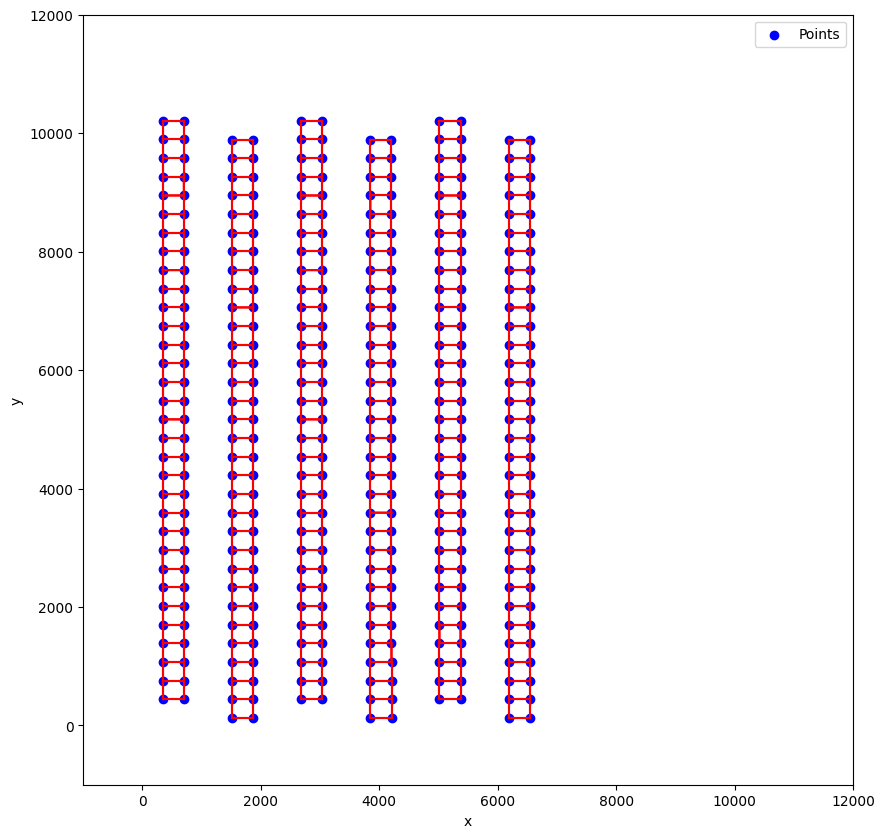

In [3]:
ngef  = "../sample/b08c/N3-HG5MC.B08C.mouse.sge_match_sbcd.png"   ## nbcd-nmatch-nge 3way image
im_nge_raw = cv2.imread(ngef, cv2.IMREAD_COLOR)
im_nge = matchraster.preprocess_image(im_nge_raw, channel=0, xy_swap=True)
circles_sbcd, im_matched = get_fiducial_mark_centers(im_nge, 'sbcd', min_dist = 200)
v_sbcd, e_sbcd = construct_grid_graph(circles_sbcd)
plot_edges(v_sbcd, e_sbcd)

/Users/yonghah/repo/historef/historef/template/fiducial_mark.HnE.png


Skipped a fiducial mark at (217, 3482) with (71, 580)
Skipped a fiducial mark at (695, 3083) with (72, 302)
Skipped a fiducial mark at (226, 3072) with (52, 449)
Skipped a fiducial mark at (5339, 770) with (165, 641)
Skipped a fiducial mark at (4791, 266) with (166, 417)
Skipped a fiducial mark at (737, 1440) with (52, 146)
Skipped a fiducial mark at (6306, 3673) with (169, 560)
Skipped a fiducial mark at (199, 3858) with (169, 896)
Skipped a fiducial mark at (6751, 4079) with (166, 599)
Skipped a fiducial mark at (6777, 3259) with (165, 505)
Skipped a fiducial mark at (4394, 256) with (164, 762)
Skipped a fiducial mark at (1991, 5111) with (164, 395)
Skipped a fiducial mark at (998, 5384) with (142, 58)
Skipped a fiducial mark at (260, 1839) with (44, 53)
Skipped a fiducial mark at (237, 2661) with (39, 269)
Skipped a fiducial mark at (6370, 1960) with (168, 310)
Skipped a fiducial mark at (998, 4682) with (163, 73)
Skipped a fiducial mark at (2164, 5445) with (151, 78)
Skipped a fidu

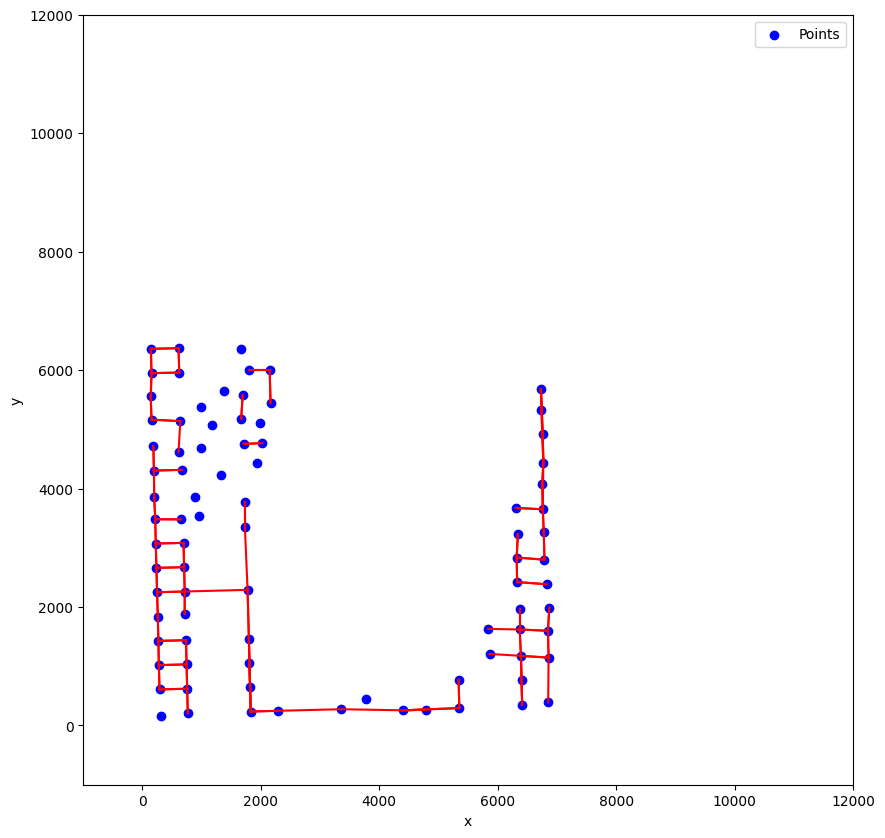

In [6]:
hnef = "../sample/b08c/10x_B08C.tif" 
im_hne_raw = cv2.imread(hnef, cv2.IMREAD_COLOR)
im_hne = intensity_cut(im_hne_raw)
im_hne = matchraster.preprocess_image(im_hne, xy_swap=True)
circles_hist, _ = get_fiducial_mark_centers(im_hne, 'HnE', min_dist = 300)
v_hist, e_hist = construct_grid_graph(circles_hist)
plot_edges(v_hist, e_hist)


We are going to identify scale factor and rotation with the grid graphs.

### identify scale factor
When we examine the lengths of the edges in grid graph, there should be two prominent peaks: horizontal edges and vertical edges. We are going to find scale factor by comparing the shorter peaks from the two graphs.

In [7]:
scale_factor, xgrid_sbcd, xgrid_hist = identify_scale_factor(e_sbcd, e_hist)

xgrid_1 / xgrid_2:: 315.5 / 411.5 = 0.7667071688942891


### Rotation
We are going to identify the proper rotation angle by minimizizng the error to the cardinal directions based on the assumption that sbcds are aligned to the cardinal direction.

In [8]:
rotation = identify_rotation_angle(e_hist)

Rotation Angle -0.5689586234236189


## Step 2. Find Candidate Transform and find best transform
Since we found rotation and scale, we need to find translation. We have limited possibility of translation since it can be limted to (V in histology graph) X (V in sbcd graph). Moreover, the possible translations are limited to the translation that bbox of histology falls inside to the bbox of sbcd.

Number of candidates: 1913


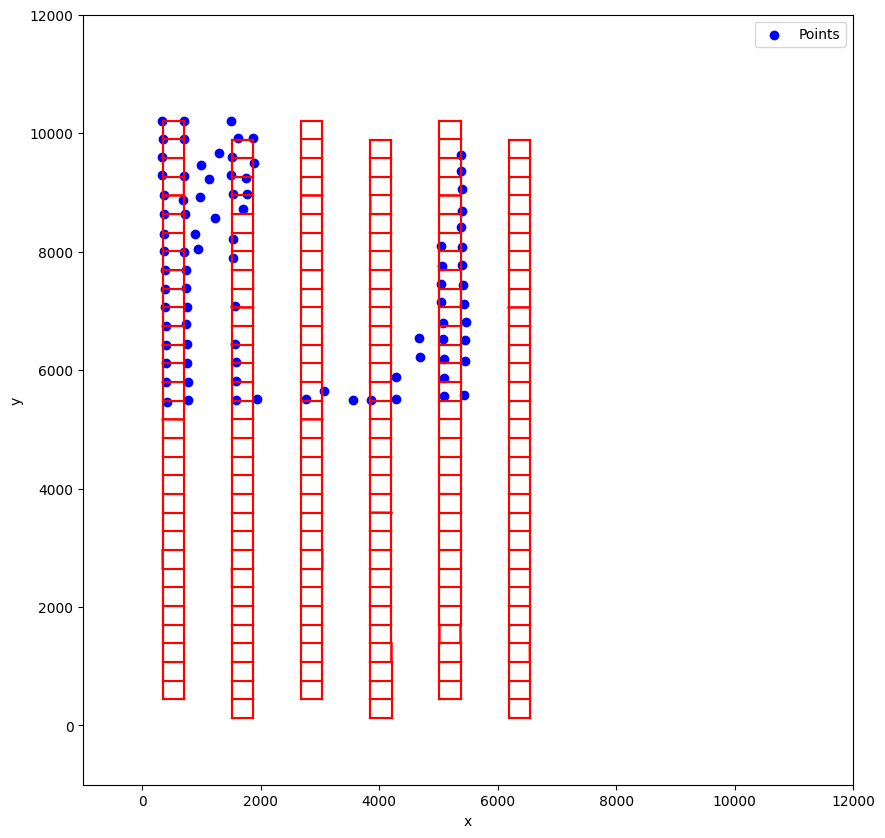

In [9]:
tms, avg_distances = find_overlapping_transform(v_sbcd, v_hist, rotation, scale_factor, max_nearest=0.33*xgrid_sbcd)
print("Number of candidates:", len(tms))
# example
v_tf = apply_transform_points(v_hist, tms[100])
plot_edges(v_tf, e_sbcd)

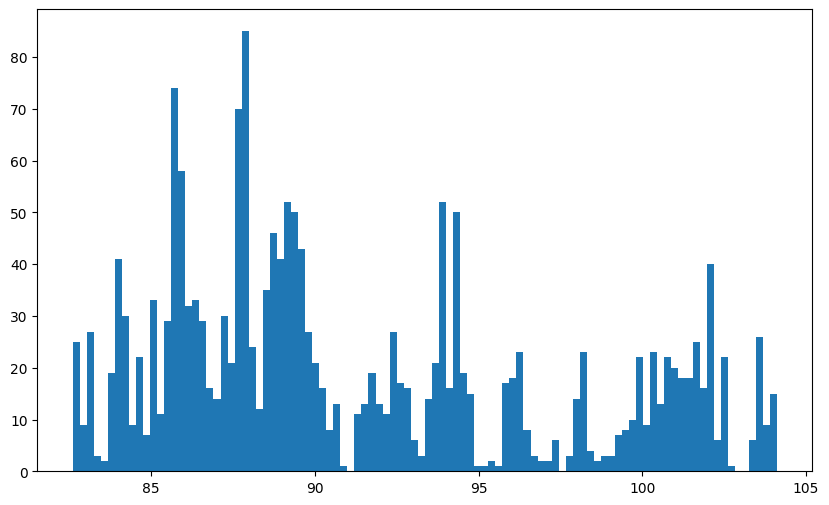

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(avg_distances, bins=100)  
plt.show()

For each transform, we apply the transform to the histology image and compare the transformed image's red channel (mostly tissue)  with sbcd's red channel (the matched barcodes).

Before doing that, we need preprocess images
- make grayscale
- set blur
- gamma

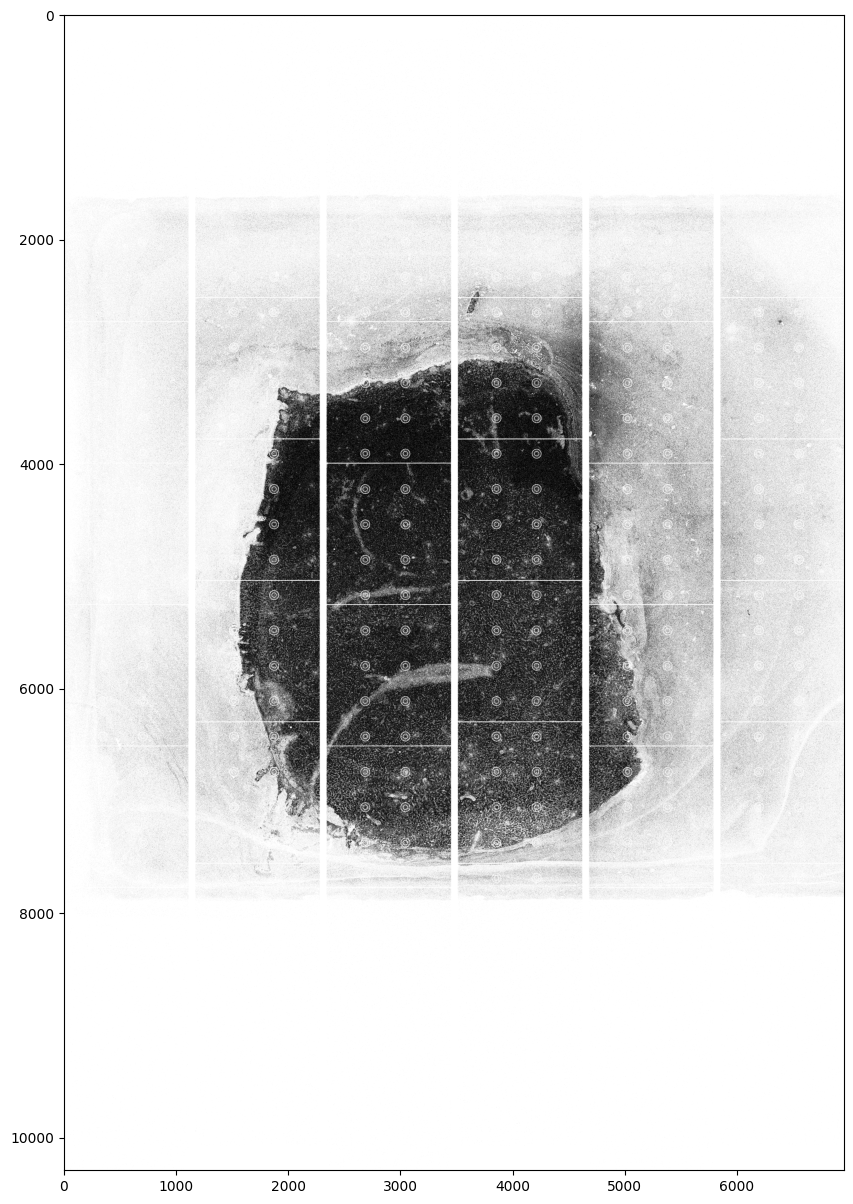

In [11]:
sbcd_lvl = matchraster.preprocess_image(im_nge_raw, xy_swap=True, channel=1, blur=1, gamma=5)
plt.figure(figsize=(15, 15))
plt.imshow(sbcd_lvl, cmap='Greys')

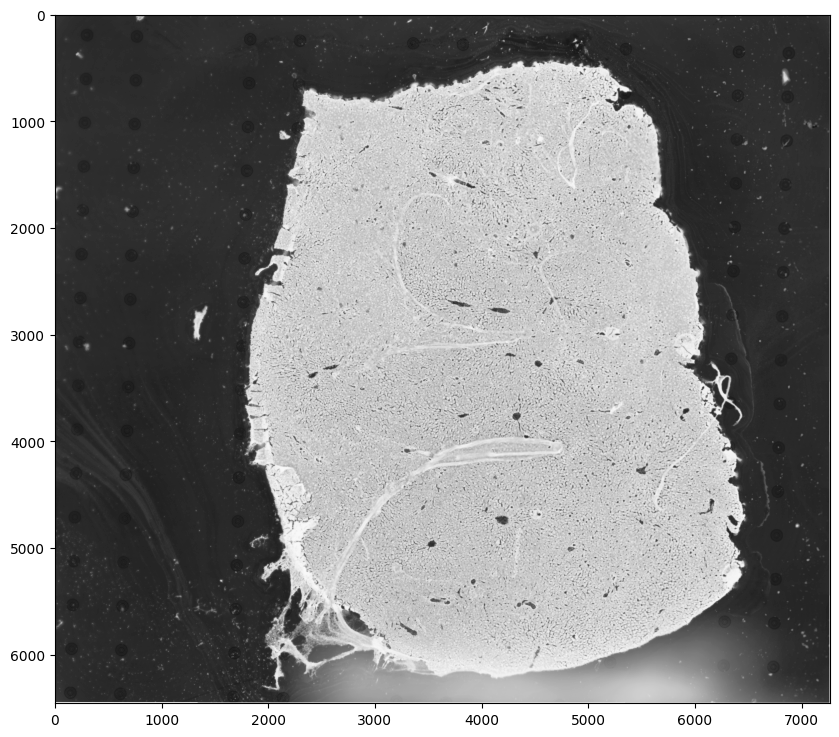

In [17]:
hist_green = matchraster.preprocess_image(im_hne_raw, xy_swap=True, channel=1, blur=None, gamma=1)
plt.figure(figsize=(10, 10))
plt.imshow(hist_green, cmap='Greys')

In [18]:
best_tf, best_idx, best_B, errors  = matchraster.find_best_transform(sbcd_lvl, hist_green, tms)

0
500
1000
1500
Best Transform: 961 (49.154758951568766)


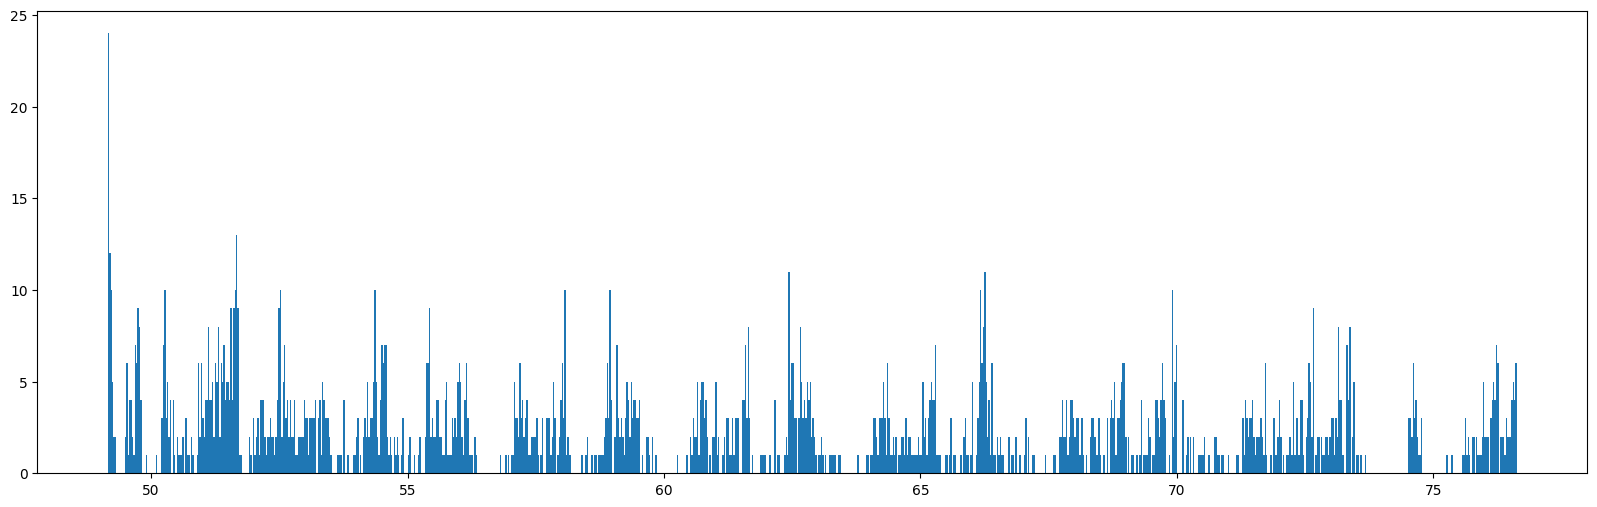

In [19]:
plt.figure(figsize=(20, 6))
plt.hist(errors, bins=1000)  
plt.show()

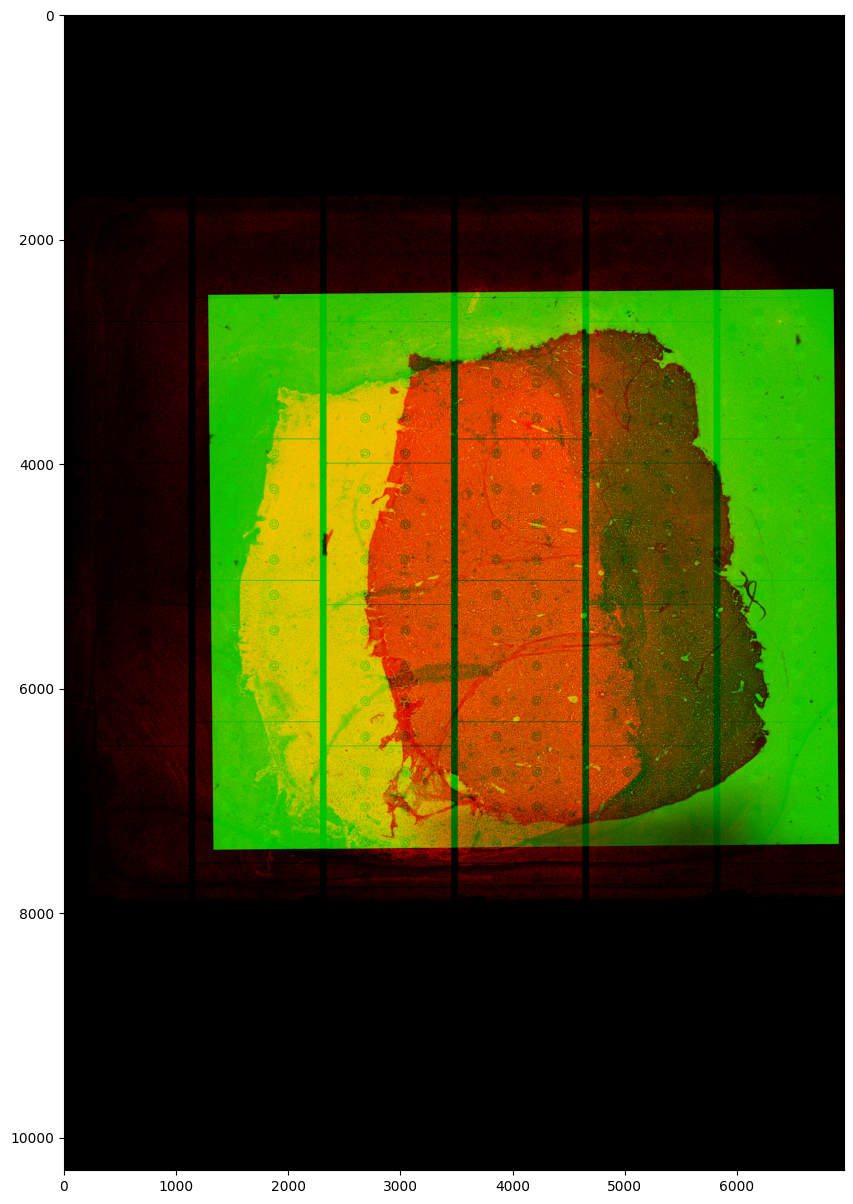

In [20]:
hist_match = cv2.warpAffine(hist_green, best_tf[:2, :], (sbcd_lvl.shape[1], sbcd_lvl.shape[0]))
zeros = np.zeros(sbcd_lvl.shape[:2], dtype="uint8")
merged = cv2.merge([sbcd_lvl, hist_match , zeros])  
plt.figure(figsize = (20,15))
plt.imshow(merged)

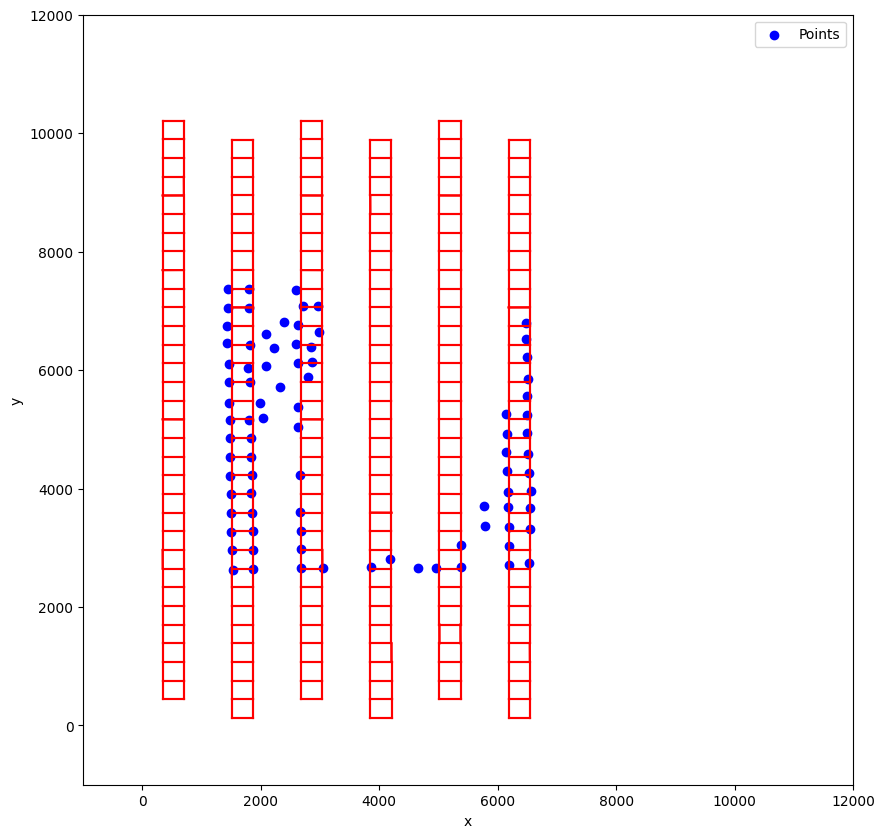

In [21]:
v_tf = apply_transform_points(v_hist, tms[best_idx])
plot_edges(v_tf, e_sbcd)

## Step3. Find GCP pairs

In [14]:
pairs = find_nearest_pairs(v_sbcd, v_hist, tms[best_idx], threshold=100)
print(len(v_tf), len(pairs))

102 98


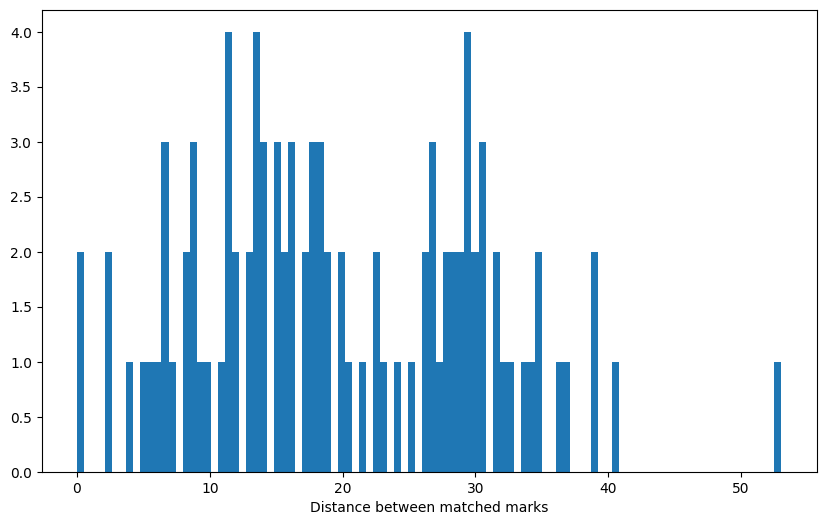

In [123]:
plt.figure(figsize=(10, 6))
plt.hist([m[3] for m in pairs], bins=100)
plt.xlabel("Distance between matched marks")
plt.show()

We are going to finally georeference the histology using the paired matches  as ground control points.

In [15]:

def gcps_from_pairs(match_pairs, rasterio=False, xy_swap=False, y_flip=False):
    gcps = []
    for p in match_pairs:
        target_x = p[2][1] if xy_swap else p[2][0]
        target_y = p[2][0] if xy_swap else p[2][1]
        target_y = -target_y if y_flip else target_y
        gcp = (p[0][1], p[0][0], target_x, target_y)
        if rasterio:
            gcps.append(GroundControlPoint(*gcp))
        else:
            gcps.append(gcp)
    return gcps

In [169]:
# this uses affine transform from gcps. Not very accurate compared to tps
gcps = gcps_from_pairs(pairs, rasterio=True, xy_swap=False, y_flip=False)
updated_file = "../sample/histology-3857-aligned_ff.tif" 
gcp_transform = from_gcps(gcps)
with rio.open(hnef, 'r+') as src:
    data = src.read()
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": "EPSG:3857",
        "transform": gcp_transform
    })
    
    with rio.open(updated_file, 'w', **new_meta) as dst:
        dst.write(data)

In [22]:
def execute_gdal_translate(gcps, input_file, output_file):
    # Build the gdal_translate command with -gcp options
    cmd = ['gdal_translate']
    
    for gcp in gcps:
        cmd.extend(['-gcp', str(gcp[0]), str(gcp[1]), str(gcp[2]), str(gcp[3])])
    
    cmd.extend(['-a_srs', 'epsg:3857', input_file, output_file])
    
    try:
        # Execute the command
        subprocess.run(cmd, check=True)
        print("gdal_translate executed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error executing gdal_translate: {e}")

def execute_gdalwarp(input_file, output_file):
    # Build the gdal_translate command with -gcp options
    cmd = ['gdalwarp']
    
    cmd.extend(['-order 2', input_file, output_file])
    
    try:
        # Execute the command
        print(" ".join(cmd))
        subprocess.run(cmd, check=True)
        print("gdal_translate executed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error executing gdal_translate: {e}")


In [24]:
gcps = gcps_from_pairs(pairs)
input_file = hnef
translate_file = "../sample/histology_translated.tif" 
warp_file = "../sample/histology_aligned.tif" 
execute_gdal_translate(gcps, input_file, translate_file)
execute_gdalwarp(translate_file, warp_file)

Input file size is 3852, 4141
0...10...20...30...40...50...60...70...80..Error executing gdal_translate: Command '['gdal_translate', '-gcp', '1502', '33', '347', '5170', '-gcp', '1296', '34', '347', '4855', '-gcp', '1091', '37', '347', '4540', '-gcp', '885', '41', '347', '4225', '-gcp', '679', '44', '347', '3910', '-gcp', '474', '48', '347', '3595', '-gcp', '269', '51', '347', '3280', '-gcp', '3561', '230', '704', '8320', '-gcp', '3356', '234', '704', '8006', '-gcp', '3151', '237', '704', '7690', '-gcp', '2946', '241', '704', '7375', '-gcp', '2740', '244', '704', '7060', '-gcp', '2534', '247', '704', '6745', '-gcp', '2328', '251', '704', '6430', '-gcp', '2122', '254', '704', '6115', '-gcp', '1916', '259', '704', '5801', '-gcp', '1711', '262', '704', '5486', '-gcp', '1506', '264', '704', '5170', '-gcp', '1300', '267', '704', '4855', '-gcp', '1095', '271', '704', '4540', '-gcp', '889', '275', '704', '4225', '-gcp', '684', '279', '704', '3910', '-gcp', '479', '281', '704', '3595', '-gcp',